# Import data

In [19]:
import sys
import csv
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition as decomposition
import sklearn.model_selection as model_select
import sklearn.tree as tree
import sklearn.metrics as metrics

In [9]:

DEBUGGING = True
DATA_DIR = 'data/data/'
DATA_FILE = 'diabetes.csv'


###### MAIN ######

# -get data from a file
try:
    df = pd.read_csv(DATA_DIR + DATA_FILE, na_filter=False)
except IOError as iox:
    print('there was an I/O error trying to open the data file: ' + str(iox))
    sys.exit()
# -get and size of raw data set
N = len(df.columns)
M = len(df.values)

# -print columns
if DEBUGGING:
    print('INPUT FILE = ' + DATA_DIR + DATA_FILE)
    print('number of attributes = ' + str(N))
    print('number of instances = ' + str(M))
    for (i, c, t) in zip(range(N), df.columns, df.dtypes):
        print('{} - {} ({})'.format(i, c, t))


INPUT FILE = data/data/diabetes.csv
number of attributes = 9
number of instances = 768
0 - preg (int64)
1 - plas (int64)
2 - pres (int64)
3 - skin (int64)
4 - insu (int64)
5 - mass (float64)
6 - pedi (float64)
7 - age (int64)
8 - class (object)


This data set contains 8 numeric features and a class.

# Data pre-processing
1. get target (class or label) and attribute values and list of feature names


2. note that we have to convert class values (labels) to an integer (index)

In [10]:


y = np.zeros(M, dtype='int')
X = np.zeros((M, N-1), dtype='float')
feature_name_dict = {'preg': 0, 'plas': 1, 'pres': 2,
                     'skin': 3, 'insu': 4, 'mass': 5, 'pedi': 6, 'age': 7}
# define indexes for class values (labels)
class_dict = {'tested_negative': 0, 'tested_positive': 1}
for i in range(N):
    if (df.columns[i] == 'class'):
        for j in range(M):
            y[j] = class_dict[df['class'][j]]
    else:
        for j in range(M):
            X[j][feature_name_dict[df.columns[i]]] = df[df.columns[i]][j]
N -= 1  # remove 'class' from number of attributes
if (DEBUGGING):
    print('shape of target=', np.shape(y))
    print('shape of attributes=', np.shape(X))
    for i in range(N):
        print(list(feature_name_dict.keys())[i], np.mean(X[i]))


shape of target= (768,)
shape of attributes= (768, 8)
preg 43.153375
plas 29.868875
pres 38.8715
skin 40.283375
insu 57.2985
mass 31.350125
pedi 38.531
age 23.67925


In [11]:

#-get a list of the unique classes in the data set
the_classes = np.unique( y )
num_classes = len( the_classes )
if ( DEBUGGING ):
    print('unique list of classes=', the_classes)

unique list of classes= [0 1]


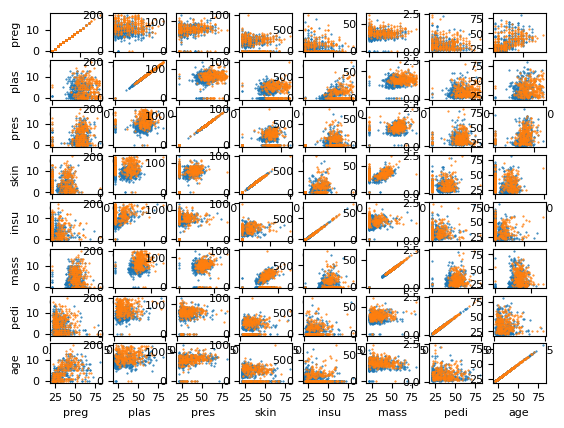

In [12]:

#-for plotting, get a "cycle" (like a dictionary) of colors
colour_cycle = plt.rcParams['axes.prop_cycle']

#-generate a scatter plot matrix of pairwise feature comparisons
plotnum = 1
for row in range( N ):
    for col in range( N ):
        plt.subplot( N, N, plotnum )
        for myclass, mycolour in zip( range( num_classes ), colour_cycle ):
            data = X[y==myclass]
            plt.scatter( data[:,row], data[:,col], s=1, marker='.', c=mycolour['color'] )
            if ( col==0 ):
                plt.ylabel( list(feature_name_dict.keys())[row], fontsize=8 )
            if ( row==N-1 ):
                plt.xlabel( list(feature_name_dict.keys())[col], fontsize=8 )
            plt.tick_params( axis='both', labelsize=8 )
        plotnum += 1
plt.savefig( 'plots/diabetes-scatter-matrix.png' )
plt.show()

# PCA

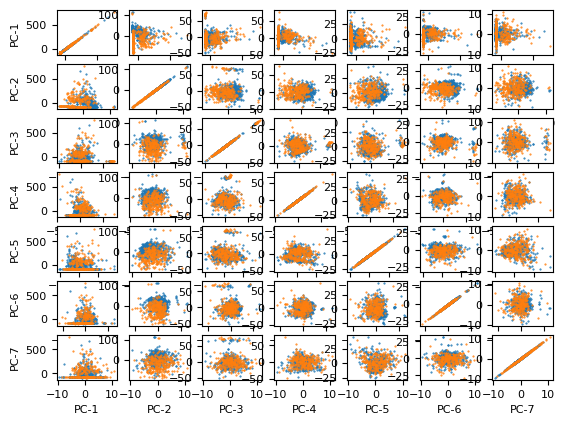

In [22]:

# -initialise principal component analysis object
# here, we set the n_components argument to be equal to the number of
# features-1, so we can look at the impact of each possible reduction
# using PCA (i.e., to 1, 2, ..., N-1 features).  but if you
# know how many principal components you want, then you can adjust
# this argument accordingly. for example, if you only want the first
# principal component, then set n_components=1.
# see:
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
pca = decomposition.PCA(n_components=N-1)

# -fit the PCA model using data set X
pca.fit(X)

# -apply dimensionality reduction to X
pca_X = pca.transform(X)
pca_N = pca_X.shape[1]

# -generate scatter plot matrix of pairwise feature comparisons using
# -the principal components just learned
plotnum = 1
for row in range(pca_N):
    for col in range(pca_N):
        plt.subplot(pca_N, pca_N, plotnum)
        for myclass, mycolour in zip(range(num_classes), colour_cycle):
            data = pca_X[y == myclass]
            plt.scatter(data[:, row], data[:, col], s=1,
                        marker='.', c=mycolour['color'])
            if (col == 0):
                plt.ylabel('PC-%d' % (row+1), fontsize=8)
            if (row == pca_N-1):
                plt.xlabel('PC-%d' % (col+1), fontsize=8)
            plt.tick_params(axis='both', labelsize=8)
        plotnum += 1
plt.savefig('plots/diabetes-pca-scatter-matrix.png')
plt.show()


# Decision Tree

In [20]:


# -initialise a decision tree classifier
print('DECISION TREE ON RAW DATA:')
clf = tree.DecisionTreeClassifier(random_state=0)

# split the raw data into training and test sets
X_train, X_test, y_train, y_test = model_select.train_test_split(
    X, y, random_state=0)
M_train = len(X_train)
M_test = len(X_test)
if (DEBUGGING):
    print('number of training instances = ' + str(M_train))
    print('number of test instances = ' + str(M_test))

# fit the tree model to the training data
clf.fit(X_train, y_train)

# predict the labels for the training and test sets
y_hat = clf.predict(X_train)
print('training accuracy = ', metrics.accuracy_score(y_train, y_hat))
y_hat = clf.predict(X_test)
print('training accuracy = ', metrics.accuracy_score(y_test, y_hat))


DECISION TREE ON RAW DATA:
number of training instances = 576
number of test instances = 192
training accuracy =  1.0
training accuracy =  0.71875


In [24]:

# -initialise a decision tree classifier
print('DECISION TREE ON PCA DATA:')
clf = tree.DecisionTreeClassifier(random_state=0)

# split the PCA data into training and test sets
X_train, X_test, y_train, y_test = model_select.train_test_split(
    pca_X, y, random_state=0)
M_train = len(X_train)
M_test = len(X_test)
if (DEBUGGING):
    print('number of training instances = ' + str(M_train))
    print('number of test instances = ' + str(M_test))

# fit the tree model to the training data
clf.fit(X_train, y_train)

# predict the labels for the training and test sets
y_hat = clf.predict(X_train)
print('training accuracy = ', metrics.accuracy_score(y_train, y_hat))
y_hat = clf.predict(X_test)
print('training accuracy = ', metrics.accuracy_score(y_test, y_hat))


DECISION TREE ON PCA DATA:
number of training instances = 576
number of test instances = 192
training accuracy =  1.0
training accuracy =  0.7395833333333334


Question:
1. How to evaluate the PCA result? Which is the best number of component?

2. What are these scatter plot used for? Guess: is there relationship between factors?

3. The result of Decision Tree is highly related to the parameters of PCA. How to select the best? 